In [1]:
import os, time, datetime
import sys
import torch
import torch.optim as optim
from tqdm import tqdm, trange
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import argparse
from argparse import Namespace

from nice import NICE
from dircluster import sample_mu_lam, SSE, LLH
from utils import savefig_clusters, mvnlogpdf, plt2img
from AE import AE

import matplotlib
# import matplotlib.pyplot as plt
import numpy as np
from numpy import log, exp, pi
from scipy.stats import wishart, gamma
from scipy.stats import multivariate_normal as normal
from numpy.linalg import inv, det
from matplotlib.patches import Ellipse
from scipy.special import loggamma
import tensorflow as tf
from scipy.stats import wishart, gamma, entropy
# from plot_cf import pretty_plot_confusion_matrix
import pandas as pd
from numpy import random
from sklearn.metrics.cluster import v_measure_score, adjusted_rand_score, pair_confusion_matrix, normalized_mutual_info_score, adjusted_mutual_info_score
# matplotlib.use('Agg')
from ae_util import *
from utils import *
from sklearn.datasets import make_blobs
from sklearn import datasets

TRAIN_BATCH_SIZE = 128
os.environ["CUDA_VISIBLE_DEVICES"] = '1'  # using specific GPU

2022-02-17 17:14:48.733442: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
seed=123456
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
def plot_cov_ellipse(lam, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    cov = (1/lam) * np.eye(2)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, fill=False, **kwargs)
#     ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, fill=True, **kwargs)

    ax.add_artist(ellip)
    return ellip

def plot_res(xs, K, ks, ns, mu_K, lam_K, color=True, contour=True, fname=None):
    print('# classes:\t', K)
    print('# counts:\t', [int(ns[i]) for i in range(K)])
    if color:
        sty = ['r.', 'g.', 'b.', 'k.', 'y.', 'c.', 'm.', 'ro', 'go', 'bo', 'ko', 'yo', 'co', 'mo']
    else:
        sty = ['b.']

    plt.figure(figsize=(5,5))
    ax = plt.gca()
    plt.axis('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for k in range(K):
        idx = (ks==k)
#         if ns[k] < 100:
#             plt.plot(xs[idx][:, 0], xs[idx][:, 1], '.', c='0.85')
#             continue
#         plt.plot(xs[idx][:, 0], xs[idx][:, 1], sty[k % len(sty)], label='class %d, mu: [%s], #: %d' % (k, mu_str, ns[k]))
        plt.plot(xs[idx][:, 0], xs[idx][:, 1], sty[k % len(sty)])
        if contour and ns[k]>100:
            mu_str = ','.join([('%.2f' % v) for v in mu_K[k]])
            plot_cov_ellipse(lam_K[k], mu_K[k], color=sty[k % len(sty)][0])
    idx = (ks==-1)
    plt.plot(xs[idx][:, 0], xs[idx][:, 1], '.', c='0.85')
    if fname is not None:
        plt.savefig(fname,  bbox_inches='tight')
    plt.show()

In [4]:
def get_iter_num(n_epoch, n_samples, cfg_list):
    '''
    How many steps for iteration in the n-th epoch
    num_iter is configed to decay for fast training 
    '''
    ratio = cfg_list[-1] if n_epoch >= len(cfg_list) else cfg_list[n_epoch]
    return int(np.ceil(n_samples * ratio))


def cluster2label(K, samples_k, y):
    map_dict = {}
    y_pred = samples_k.copy()
    for k_idx in range(K):  # analysis each cluster
        cluster_sid = (samples_k == k_idx)
        label, counts = np.unique(y[cluster_sid], return_counts=True)
        major_class_idx = np.argmax(counts)

        map_dict[k_idx] = label[major_class_idx]
        y_pred[cluster_sid] = label[major_class_idx]
    return y_pred, map_dict


def pair_f1_score(ys, ks):
    cf = pair_confusion_matrix(ys, ks)
    # TN, FP
    # FN, TP
    return cf[1, 1] / float(cf[1, 1] + 0.5 * (cf[0, 1] + cf[1, 0]))


def get_count_matrix(K, cluster_label, nC, label):
    # count labels in each cluster
    np.unique(cluster_label)
    cluster_counts_list = []
    for k in range(K):
        c_sample_id = (cluster_label == k)
        y, ny = np.unique(label[c_sample_id], return_counts=True)
        counts_arr = np.zeros(nC)
        counts_arr[y] = ny
        cluster_counts_list.append(counts_arr)
    count_matrix = np.stack(cluster_counts_list, axis=0)
    return count_matrix


def cluster_acc_fixed(Y_pred, Y):  # from paper VaDE code
    from scipy.optimize import linear_sum_assignment as linear_assignment
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    a, b = linear_assignment(w.max() - w)
    ind = [(a[i], b[i]) for i in range(a.shape[0])]
    return sum([w[i, j] for i, j in ind]) * 1.0 / Y_pred.size, ind


def eval_cluster(samples_k, ys, return_extra=False, alg='default', ds_name='default'):
    cids, nK = np.unique(samples_k, return_counts=True)
    k_indices = np.argsort(-nK)  # desc sort by size
    k_major, k_entropy = [], []
    confusion_matrix = np.zeros(shape=(10, 10))
    correct = 0
    for k_idx in k_indices:  # analysis each cluster
        cluster_sid = (samples_k == cids[k_idx])
        cluster_size = nK[k_idx]
        label, counts = np.unique(ys[cluster_sid], return_counts=True)
        k_entropy.append(entropy(counts / cluster_size))

        major_class_idx = np.argmax(counts)
        k_major.append(label[major_class_idx])
        confusion_matrix[label, label[major_class_idx]] += counts
        correct += counts[major_class_idx]
    acc = correct / np.sum(nK)
    weighted_entropy = np.sum(nK[k_indices]/np.sum(nK) * k_entropy)

    # k-irrevlent measure
    v_score, adj_rand = v_measure_score(ys, samples_k), adjusted_rand_score(ys, samples_k),
    pair_f1 = pair_f1_score(ys, samples_k)
    if not return_extra:
        # print(f'{alg} on {ds_name}:\n\t F score | V score | ARI | ACC* | K | wEntropy :\n\t'
        #       f'{pair_f1:.4f} & {v_score:.4f} & {adj_rand:.4f} & {acc:.4f} & {len(cids)} & {weighted_entropy:.4f}')
        return acc, v_score, adj_rand, pair_f1, weighted_entropy, confusion_matrix
    else:
        nmi = normalized_mutual_info_score(ys, samples_k)
        # print(f'{alg} on {ds_name}:\n\t F score | V score | ARI | NMI | ACC* | K | wEntropy :\n\t'
        #       f'{pair_f1:.4f} & {v_score:.4f} & {adj_rand:.4f} & {nmi:.4f} & {acc:.4f} & {len(cids)} & {weighted_entropy:.4f}')
        return pair_f1, v_score, adj_rand, nmi, acc, len(cids), weighted_entropy, confusion_matrix


def dirichlet_clustering(global_epoch, tb_writter, dir_params, samples, ys, n_iter_samples, args, log_step=0):
    # samples contains the full dataset, but used sample is indicated by n_sample_load
    # extract variables
    hp = dir_params.hyper
    _mu0, _ka0, logalpha, _a0, _b0 = hp.mu0, hp.ka0, hp.logalpha, hp.a0, hp.b0
    K, lam_K, mu_K, nK, ks = dir_params.K, dir_params.lam_K, dir_params.mu_K, dir_params.n_K, dir_params.samples_k

    
    monitor_freq = 100
    with tb_writter.as_default():
        for iter_idx in range(n_iter_samples):
            ## report result
            global_log_step = iter_idx+log_step
            sample_idx = global_log_step % len(ks)  # mod by n_sample_load 
            xi = samples[sample_idx]
            old_k = ks[sample_idx]
            if old_k != -1: 
                nK[old_k] -= 1
                if nK[old_k] == 0:   
                    idx = (ks == K - 1)
                    ks[idx] = old_k
                    nK[old_k], lam_K[old_k], mu_K[old_k], = nK[K - 1], lam_K[K - 1], mu_K[K - 1]
                    nK, lam_K, mu_K = nK[:-1], lam_K[:-1], mu_K[:-1]
                    K -= 1

            # 3.1.1 Sampling Cluster Assingment k
            p_lst = []  # p_lst[k] is the probability that xi in C_k, p_lst[-1] means xi forms a new cluster
            Kn = K
            if K == 0:  # if no cluster, just build a new one
                chosen_k = 0
            else:
                # existing cluster assignment prob
                Klst = np.random.choice(K, size=Kn, replace=False, p=np.asarray(nK) / np.sum(np.asarray(nK)))
                for k in Klst:
                    pk = log(nK[k]) + mvnlogpdf(xi, mu_K[k], 1 / lam_K[k])
                    p_lst.append(pk)

                # new cluster assignment pob.
                _kan = _ka0 + 1
                _an = _a0 + 0.5 * args.dim
                _bn = _b0 + _ka0 * np.linalg.norm(xi - _mu0) ** 2 / (2 * (_ka0 + 1))
                logpk = log(logalpha) + \
                        loggamma(_an) - loggamma(_a0) + \
                        _a0 * log(_b0) - _an * log(_bn) + \
                        0.5 * (log(_ka0) - log(_kan)) - args.dim / 2 * log(2 * pi)
                p_lst.append(logpk)

                # sampling according to the assignment prob.
                maxpk = max(p_lst)
                p_lst = [exp(v - maxpk) for v in p_lst] 
                chosen_k = np.random.choice(list(range(Kn + 1)),
                                            p=p_lst / sum(p_lst))  # sample, now xi belongs cluster chosen_k

            # 3.1.2 Sampling Cluster mean and lambda
            if chosen_k == Kn:  # assigned to new cluster
                nK.append(1)
                ks[sample_idx] = K
                lam_k, mu_k = sample_mu_lam(samples, nK, ks, chosen_k, _mu0, _ka0, _a0, _b0)
                mu_K.append(mu_k)
                lam_K.append(lam_k)
                K += 1
            else:  # assigned to existing cluster
                chosen_k = Klst[chosen_k]
                nK[chosen_k] += 1
                ks[sample_idx] = chosen_k 
            if sample_idx % args.dmm_rebuild_freq == 0 or sample_idx == args.n_sample_load:
                for k in range(K):
                    lam_K[k], mu_K[k] = sample_mu_lam(samples, nK, ks, k, _mu0, _ka0, _a0, _b0) 
    # update params
    dir_params.K, dir_params.lam_K, dir_params.mu_K, dir_params.n_K, dir_params.samples_k = K, lam_K, mu_K, nK, ks
    return dir_params


def train_flow(global_epoch, tb_writter, model_nice, opt, ds_inf_iter, n_iter, dir_params, args,
               log_step=0, prev_z_repr=None):
    if n_iter == 0:
        print('flow_opt=0, train ignored')
        return
    model_nice = model_nice.to(args.device)
    epoch_n_batch = args.n_sample_load // TRAIN_BATCH_SIZE
    epoch_loss, epoch = 0.0, 0
    K, ks, ns, mu_K, lam_K = dir_params.K, dir_params.samples_k, dir_params.n_K, dir_params.mu_K, dir_params.lam_K

    model_nice.to(args.device)
    with tb_writter.as_default():
        for n_batch in range(n_iter):
            (_, x, _, idx) = next(ds_inf_iter)
            x = x.to(args.device) 
            model_nice.train()
            opt.zero_grad() 
            x = x.to(args.device)
            _, likelihood = model_nice(x, K, ks[idx.numpy()], ns, np.asarray(mu_K), np.asarray(lam_K) )
            if isinstance(likelihood, int):
                continue
            loss = -torch.mean(likelihood)  # NLL
 
            loss.backward() 
            opt.step() 


def init_dir_params(args):
    dir_params = Namespace(
        hyper=Namespace(
            a0=args.a0 * args.dim, b0=args.b0 * args.dim,
            mu0=np.zeros(args.dim), ka0=args.kappa0,
            logalpha=args.logalpha
        ),
        K=0, n_K=[], lam_K=[], mu_K=[], samples_k=np.ones(args.n_sample_load, dtype=int) * -1 
    )
    return dir_params


def init_flow_model(args):
    model_nice = NICE(data_dim=args.dim, num_coupling_layers=args.nice_nlayers,
                      num_hidden_units=args.nice_units, device_name=args.device)
    opt = optim.Adam(model_nice.parameters(), args.lr)
    return model_nice, opt


def load_ae_dataset(ds_name, n_sample_load, aex_file):
    print('start loading ae dataset')
    if ds_name == 'syn_Gaussian':
        n_samples = n_sample_load
        random_state = 170
        X, Y = make_blobs(n_samples=n_samples, random_state=random_state)
        Z = X
        ds_ae_repr = torch.from_numpy(Z)[:n_sample_load]
        ds_ae = OtherAEDataset(X, Y, Z, n_sample_load)

        plt.plot()
        plt.scatter(X[:, 0], X[:, 1])
        plt.show()
    elif ds_name == 'syn_Gaussian2':
        kk=0.2
        mm=3
        n_samples = n_sample_load
        nn = n_samples // 3
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples, dtype=np.int)
        X[:nn] = random.multivariate_normal([-mm,mm], [[1,0],[0,kk]], size=nn)
        X[nn:2*nn] = random.multivariate_normal([mm,mm], [[kk,0],[0,1]], size=nn)
        X[2*nn:] = random.multivariate_normal([0,-mm], [[1,kk],[kk,1]], size=n_samples-2*nn)
        Y[:nn] = 0
        Y[nn:2*nn] = 1
        Y[2*nn:] = 2
        Z = X
        ds_ae_repr = torch.from_numpy(Z)[:n_sample_load]
        ds_ae = OtherAEDataset(X, Y, Z, n_sample_load)

        plt.plot()
        plt.scatter(X[:, 0], X[:, 1])
        plt.show()
    elif ds_name == 'moon':
        n_samples = n_sample_load
        random_state = 170
        X, Y = datasets.make_moons(n_samples=n_samples, random_state=random_state)
        Z = X
        ds_ae_repr = torch.from_numpy(Z)[:n_sample_load]
        ds_ae = OtherAEDataset(X, Y, Z, n_sample_load)

        plt.plot()
        plt.scatter(X[:, 0], X[:, 1])
        plt.show()
    else:
        raise ValueError(f'dataset name {ds_name} not supported')
    return ds_ae_repr, ds_ae

In [5]:
class TmpArgs:
    def __init__(self):
        self.dataset = 'syn_Gaussian2'
        self.dim = 2
        self.noise = 0.0 
        self.n_sample_load = 1500
        self.epoch = 30
        self.iter_dmm = 1500*3
        self.dmm_rebuild_freq = 50
        self.iter_nice = 50
        self.save_freq = 1
        self.lr = 0.0001 
        self.logalpha = 1
        self.kappa0 = 5
        self.a0 = 0.1
        self.b0 = 0.01 
        self.nice_nlayers = 6
        self.nice_units = 512 
        self.exp_name = 'exp_syn_Gaussian'
        self.pretrainpath = 'NA'
        self.aex_file = 'NA'
        self.device = 'cuda'
        self.log_dir = './exp_out/syn_Gaussian2'

start loading ae dataset


/home/linaiqi/anaconda3/envs/jack/lib/python3.7/site-packages/ipykernel_launcher.py:227: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


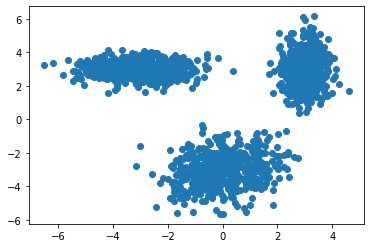

data loaded, cls dist: N=1500[[  0   1   2]
 [500 500 500]]
transfrom consumed 2.8s


In [6]:
args = TmpArgs()    #parse_args(manual_args)
time_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
exp_id = '%s_%s_N%d_E%d_kappa0_%s_a0_%s_b0_%s_alpha_%s_%s_p%s' % (
        args.exp_name, args.dataset, args.n_sample_load, args.epoch, args.kappa0, args.a0, args.b0, args.logalpha, time_str, os.getpid())
task_dir = os.path.join(args.log_dir, exp_id)
if not os.path.exists(task_dir):
    os.makedirs(task_dir)

# 1. load AE dataset
ds_ae_repr, ds_ae = load_ae_dataset(args.dataset, args.n_sample_load, args.aex_file)
dl_ae = InfiniteDataLoader(dataset=ds_ae, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)
iter_ae_inf = iter(dl_ae)
print(f'data loaded, cls dist: N={args.n_sample_load}'
      f'{np.stack(np.unique(ds_ae.targets, return_counts=True))}')

# 2. init model nice
model_nice, opt = init_flow_model(args)

# 3. init dirichlet mixture model
dir_params = init_dir_params(args)
samples_flow_z = transform_z(model_nice, ds_ae, args.n_sample_load)

# classes:	 3
# counts:	 [0, 0, 0]


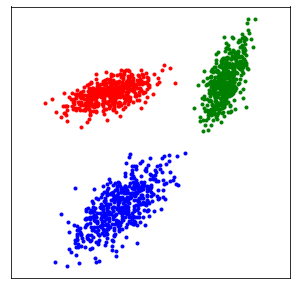

In [7]:
plot_res(samples_flow_z, 3, ds_ae.targets, ds_ae.targets, dir_params.mu_K, dir_params.lam_K, color=True, contour=False, fname='./fig/cl_gt.pdf')

2022-02-17 17:14:55.154331: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-17 17:14:55.154878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-17 17:14:55.155622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:85:00.0 name: Tesla M60 computeCapability: 5.2
coreClock: 1.1775GHz coreCount: 16 deviceMemorySize: 7.94GiB deviceMemoryBandwidth: 149.31GiB/s
2022-02-17 17:14:55.155645: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-17 17:14:55.155680: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-17 17:14:55.155701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-02-17 

27457-DDPM training epoch 0
transfrom consumed 2.7s
# classes:	 0
# counts:	 []


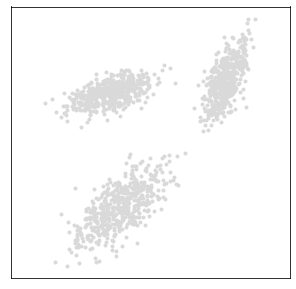

# classes:	 0
# counts:	 []


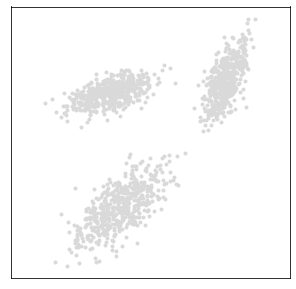

27457-DDPM training epoch 1
transfrom consumed 2.7s
# classes:	 3
# counts:	 [495, 500, 505]


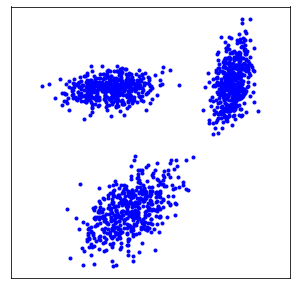

# classes:	 3
# counts:	 [495, 500, 505]


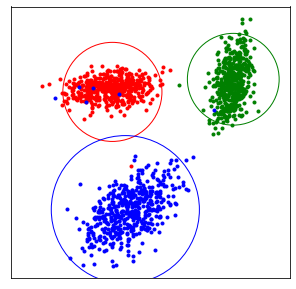

27457-DDPM training epoch 2
transfrom consumed 2.8s
# classes:	 3
# counts:	 [499, 501, 500]


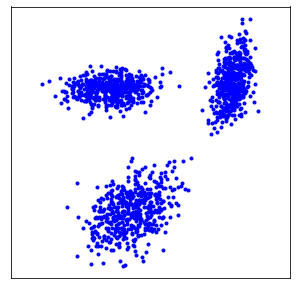

# classes:	 3
# counts:	 [499, 501, 500]


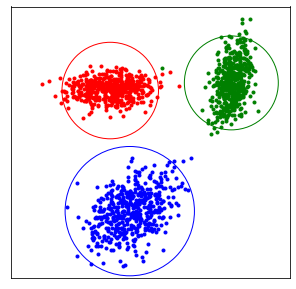

27457-DDPM training epoch 3
transfrom consumed 2.7s
# classes:	 3
# counts:	 [498, 502, 500]


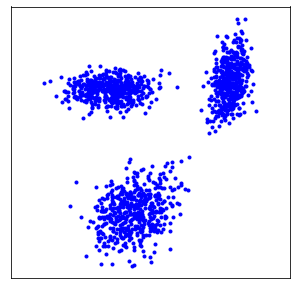

# classes:	 3
# counts:	 [498, 502, 500]


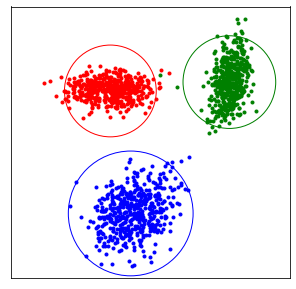

27457-DDPM training epoch 4
transfrom consumed 2.7s
# classes:	 3
# counts:	 [499, 501, 500]


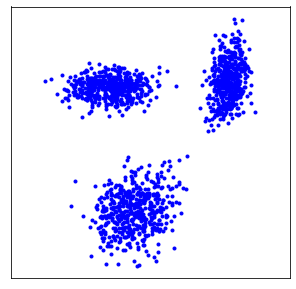

# classes:	 3
# counts:	 [499, 501, 500]


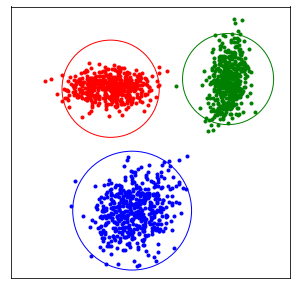

27457-DDPM training epoch 5
transfrom consumed 2.7s
# classes:	 3
# counts:	 [497, 504, 499]


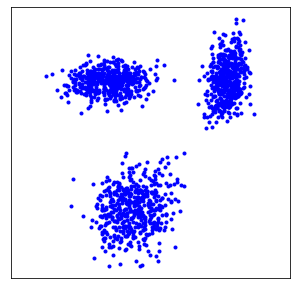

# classes:	 3
# counts:	 [497, 504, 499]


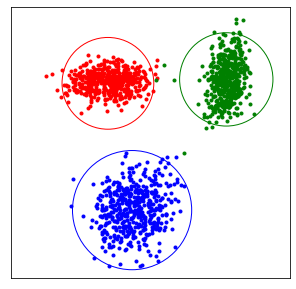

27457-DDPM training epoch 6
transfrom consumed 2.7s
# classes:	 3
# counts:	 [499, 501, 500]


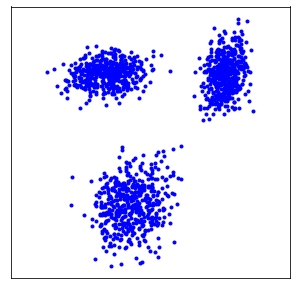

# classes:	 3
# counts:	 [499, 501, 500]


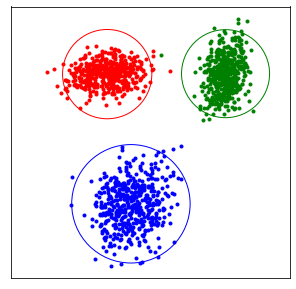

27457-DDPM training epoch 7
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


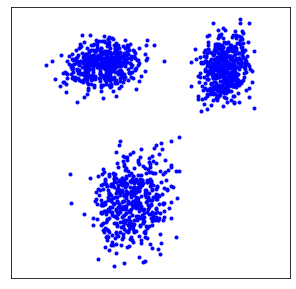

# classes:	 3
# counts:	 [500, 500, 500]


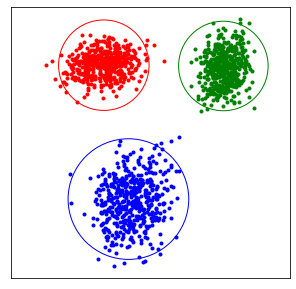

27457-DDPM training epoch 8
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


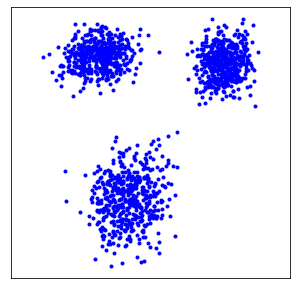

# classes:	 3
# counts:	 [500, 500, 500]


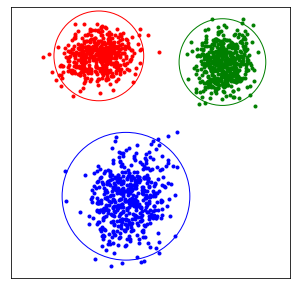

27457-DDPM training epoch 9
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


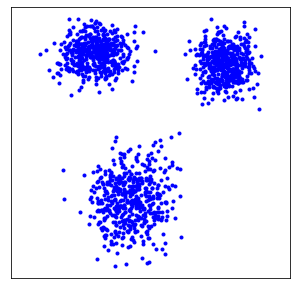

# classes:	 3
# counts:	 [500, 500, 500]


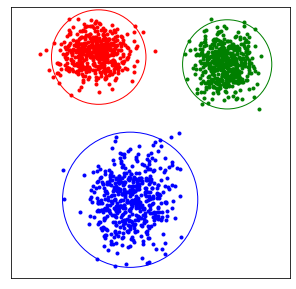

27457-DDPM training epoch 10
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


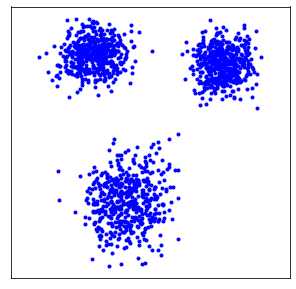

# classes:	 3
# counts:	 [500, 500, 500]


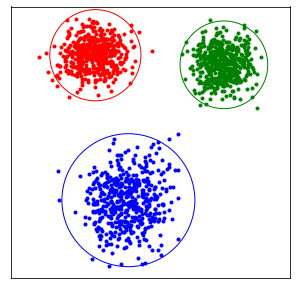

27457-DDPM training epoch 11
transfrom consumed 2.7s
# classes:	 4
# counts:	 [498, 501, 500, 1]


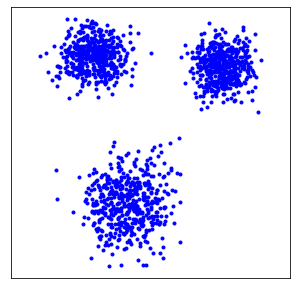

# classes:	 4
# counts:	 [498, 501, 500, 1]


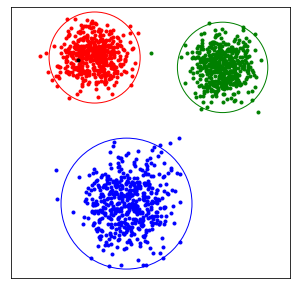

27457-DDPM training epoch 12
transfrom consumed 2.7s
# classes:	 4
# counts:	 [499, 501, 499, 1]


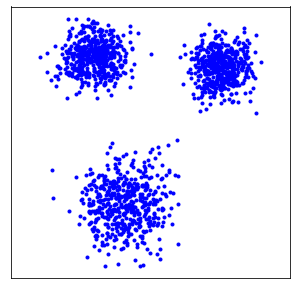

# classes:	 4
# counts:	 [499, 501, 499, 1]


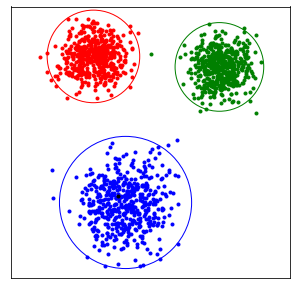

27457-DDPM training epoch 13
transfrom consumed 2.9s
# classes:	 3
# counts:	 [500, 500, 500]


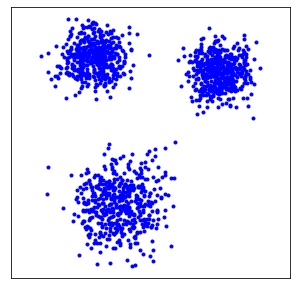

# classes:	 3
# counts:	 [500, 500, 500]


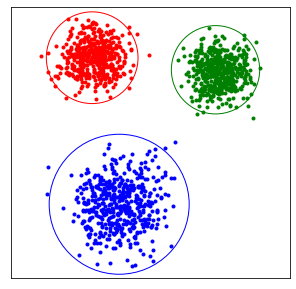

27457-DDPM training epoch 14
transfrom consumed 2.8s
# classes:	 3
# counts:	 [499, 500, 501]


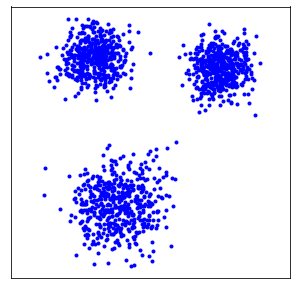

# classes:	 3
# counts:	 [499, 500, 501]


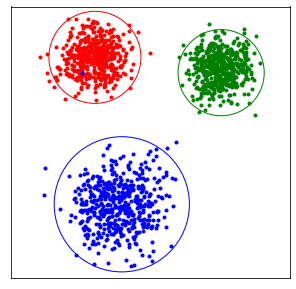

27457-DDPM training epoch 15
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


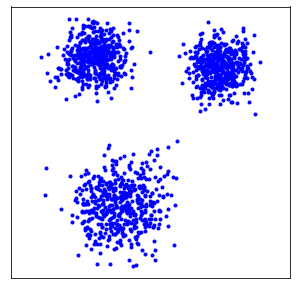

# classes:	 3
# counts:	 [500, 500, 500]


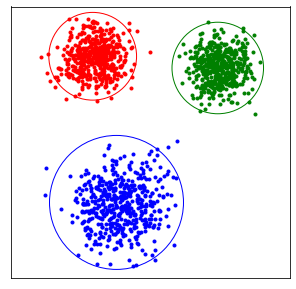

27457-DDPM training epoch 16
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


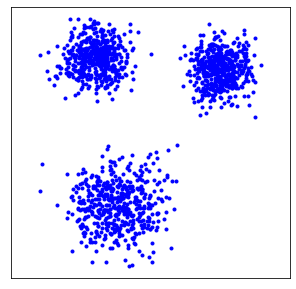

# classes:	 3
# counts:	 [500, 500, 500]


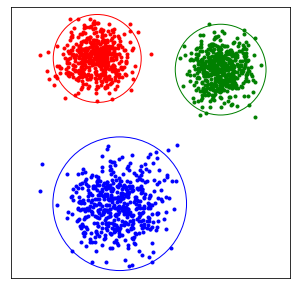

27457-DDPM training epoch 17
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


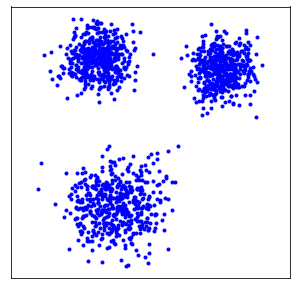

# classes:	 3
# counts:	 [500, 500, 500]


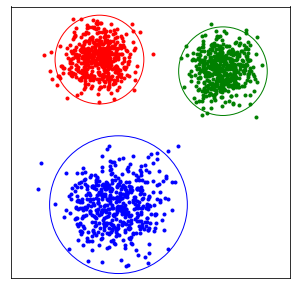

27457-DDPM training epoch 18
transfrom consumed 2.7s
# classes:	 4
# counts:	 [498, 501, 500, 1]


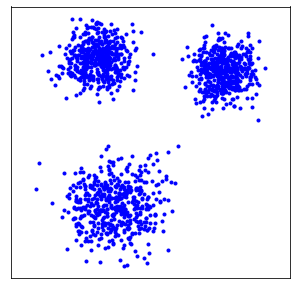

# classes:	 4
# counts:	 [498, 501, 500, 1]


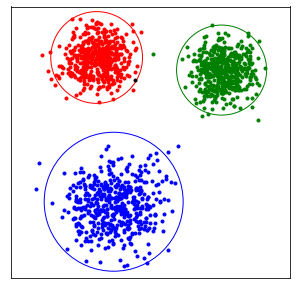

27457-DDPM training epoch 19
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


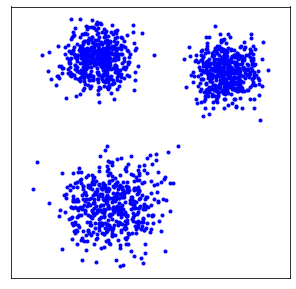

# classes:	 3
# counts:	 [500, 500, 500]


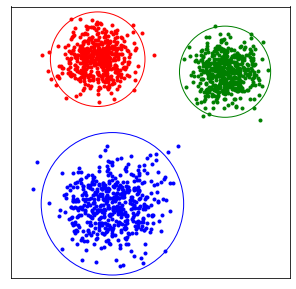

27457-DDPM training epoch 20
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


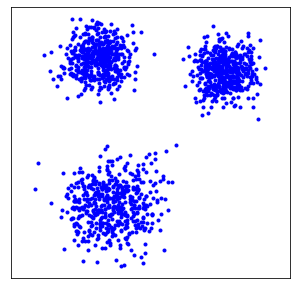

# classes:	 3
# counts:	 [500, 500, 500]


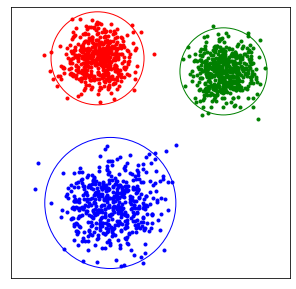

27457-DDPM training epoch 21
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


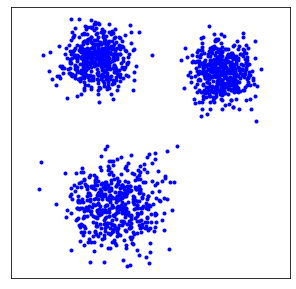

# classes:	 3
# counts:	 [500, 500, 500]


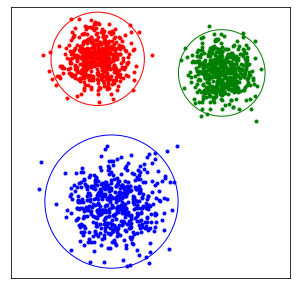

27457-DDPM training epoch 22
transfrom consumed 2.7s
# classes:	 4
# counts:	 [499, 500, 500, 1]


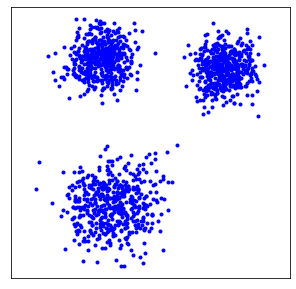

# classes:	 4
# counts:	 [499, 500, 500, 1]


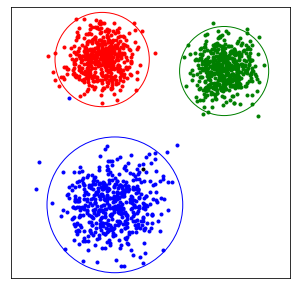

27457-DDPM training epoch 23
transfrom consumed 2.9s
# classes:	 3
# counts:	 [500, 500, 500]


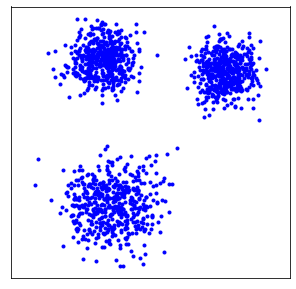

# classes:	 3
# counts:	 [500, 500, 500]


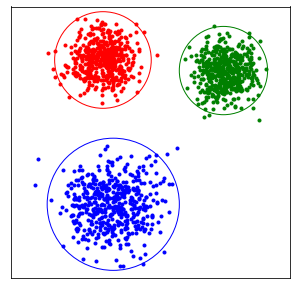

27457-DDPM training epoch 24
transfrom consumed 2.7s
# classes:	 3
# counts:	 [500, 500, 500]


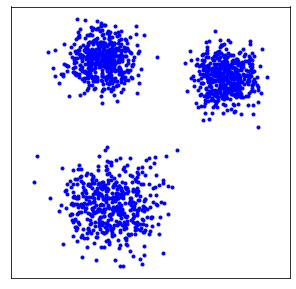

# classes:	 3
# counts:	 [500, 500, 500]


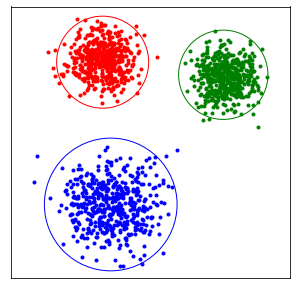

27457-DDPM training epoch 25
transfrom consumed 3.6s
# classes:	 3
# counts:	 [498, 500, 502]


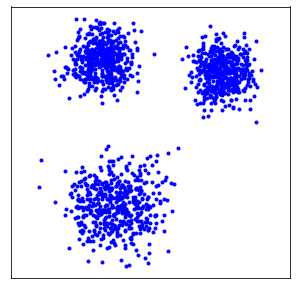

# classes:	 3
# counts:	 [498, 500, 502]


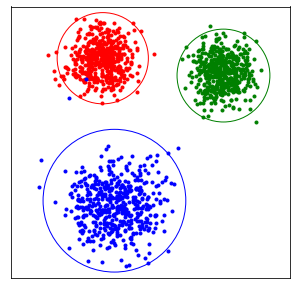

27457-DDPM training epoch 26
transfrom consumed 3.6s
# classes:	 4
# counts:	 [498, 500, 501, 1]


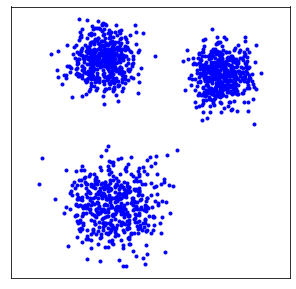

# classes:	 4
# counts:	 [498, 500, 501, 1]


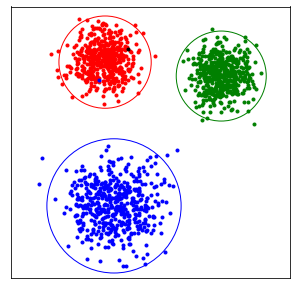

27457-DDPM training epoch 27
transfrom consumed 3.5s
# classes:	 3
# counts:	 [500, 500, 500]


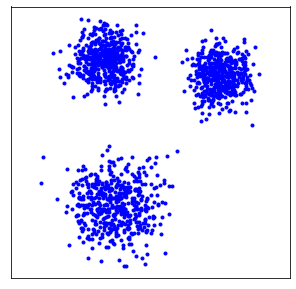

# classes:	 3
# counts:	 [500, 500, 500]


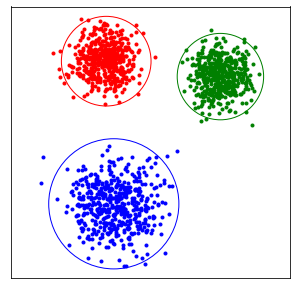

27457-DDPM training epoch 28
transfrom consumed 3.5s
# classes:	 3
# counts:	 [500, 500, 500]


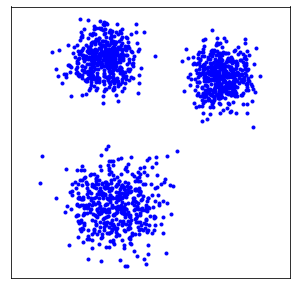

# classes:	 3
# counts:	 [500, 500, 500]


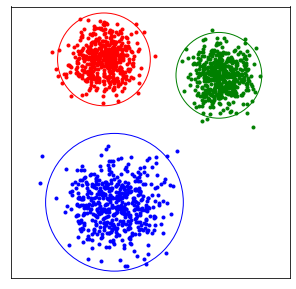

27457-DDPM training epoch 29
transfrom consumed 3.5s
# classes:	 3
# counts:	 [500, 500, 500]


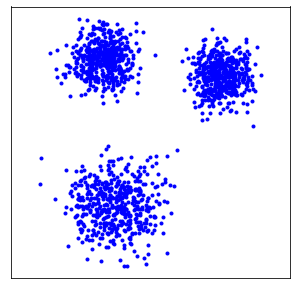

# classes:	 3
# counts:	 [500, 500, 500]


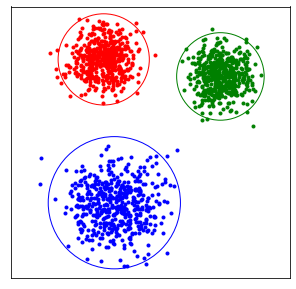

In [8]:
# 4.alternated training
tb_logger = tf.summary.create_file_writer(task_dir)
with tb_logger.as_default():
    tf.summary.text('config', str(args), step=0)
    tf.summary.text('flow arch', str(model_nice), step=0)
    tf.summary.histogram('total distance norm init AE', torch.norm(ds_ae_repr, dim=1).cpu().numpy(), step=-1)
    tb_logger.flush()
global_step_dmm, global_step_flow = 0, 0
for n_epoch in range(args.epoch):
    print(f'{os.getpid()}-DDPM training epoch {n_epoch}') 
    samples_flow_z = transform_z(model_nice, ds_ae, args.n_sample_load)
    plot_res(samples_flow_z, dir_params.K, dir_params.samples_k, dir_params.n_K, dir_params.mu_K, dir_params.lam_K, color=False, contour=False, fname='./fig/bw_%d.pdf'%n_epoch)
    plot_res(samples_flow_z, dir_params.K, dir_params.samples_k, dir_params.n_K, dir_params.mu_K, dir_params.lam_K, color=True, contour=True, fname='./fig/cl_%d.pdf'%n_epoch)
#         samples_flow_z = samples_flow_z.detach().cpu().numpy() 
    n_iter_clst = args.iter_dmm
    dir_params = dirichlet_clustering(n_epoch, tb_logger, dir_params, samples_flow_z, ds_ae.targets, n_iter_clst, args, log_step=global_step_dmm)
    global_step_dmm += n_iter_clst+1

    # 3. flow model trainging
    n_iter_opt = args.iter_nice
    train_flow(n_epoch, tb_logger, model_nice, opt, iter_ae_inf, n_iter_opt, dir_params, args,
               log_step=global_step_flow, prev_z_repr=samples_flow_z)
    global_step_flow += n_iter_opt+1 

# classes:	 3
# counts:	 [498, 500, 502]


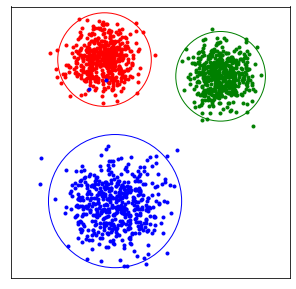

In [9]:
plot_res(samples_flow_z, dir_params.K, dir_params.samples_k, dir_params.n_K, dir_params.mu_K, dir_params.lam_K, color=True, contour=True, fname='./fig/cl_final.pdf')

# classes:	 3
# counts:	 [498, 500, 502]


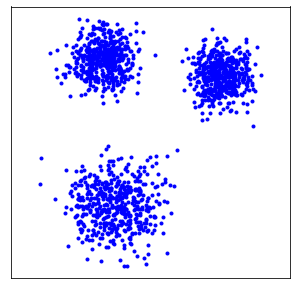

In [10]:
plot_res(samples_flow_z, dir_params.K, dir_params.samples_k, dir_params.n_K, dir_params.mu_K, dir_params.lam_K, color=False, contour=False, fname='./fig/bw_final.pdf')